In this notebook, I want to see if from the PCNA values, a model can output the DAPI, Cyclin A2 and EdU values

In [1]:
#I think we would want to go from the PCNA crop to guess the average DAPI value

#Let's get the PCNA numpys
import pandas as pd
import numpy as np
from ccc_nn_functions import str2array

csv_file = r'C:\Users\rz200\Documents\development\cell-SCT\classification\imported_CSV\dataframe_821'
df = pd.read_csv(csv_file)

In [2]:
def df_ignore_rows(df):
    indices_to_skip_img_wrong_shape = [i for i in range(len(df)) if str2array(df['pcna_crops'][i]).dtype is np.dtype('object')]  # skipping rows with shapes such as (7,)
    indices_to_skip_no_class = df[(df['G1_Phase'] == False) & (df['S_Phase'] == False) & (df['G2_M_Phase'] == False)].index

    rows_to_ignore = np.concatenate((indices_to_skip_img_wrong_shape, indices_to_skip_no_class), axis=0)
    df = df.drop(set(rows_to_ignore)).reset_index(drop=True) #dropping the rows to ignore

    return df

df = df_ignore_rows(df)

C:\Users\rz200\Documents\development\cell-SCT\classification\ccc_nn_functions.py:106: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(ast.literal_eval(s))


In [4]:
def get_pcna_crops_flat_pad(df):
    pcna_crops = []
    for i in range(len(df)): pcna_crops.append(str2array(df['pcna_crops'][i]))
    #We'll want to flatten all of these arrays
    pcna_crops_flat = []
    for i in range(len(pcna_crops)):
        pcna_crops_flat.append(pcna_crops[i].flatten())
    #Then we want to get the longest one
    max_shape = max([flat_crop.shape[0] for flat_crop in pcna_crops_flat])
    #Then we want to add 0s at the end of everyone that isn't as long as the longest one
    pcna_crops_flat_pad = []
    for i in range(len(pcna_crops_flat)):
        A = pcna_crops_flat[i]
        pad_size = max_shape - A.shape[0]
        new_arr = np.pad(A, (0, pad_size), 'constant')
        pcna_crops_flat_pad.append(new_arr)
    pcna_crops_flat_pad = np.array(pcna_crops_flat_pad)

    return pcna_crops_flat_pad

pcna_crops_flat_pad = get_pcna_crops_flat_pad(df)

KeyboardInterrupt: 

In [5]:
def get_label_values(df):
    dapi_values = []
    cyclina2_values = []
    edu_values = []
    dna_values = []
    pcna_values = []
    for i in range(len(df)):
        dapi_values.append(df['dapi_values'][i])
        cyclina2_values.append(df['cyclina2_values'][i])
        edu_values.append(df['edu_values'][i])
        dna_values.append(df['DNA_content'][i])
        pcna_values.append(df['pcna_values'][i])
    dapi_values = np.array(dapi_values)
    cyclina2_values = np.array(cyclina2_values)
    edu_values = np.array(edu_values)
    dna_values = np.array(dna_values)
    pcna_values = np.array(pcna_values)

    return dapi_values,cyclina2_values,edu_values,dna_values, pcna_values

dapi_values, cyclina2_values, edu_values, dna_values, pcna_values = get_label_values(df)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statistics import mean

def off_score(model,X,y):
    predictions = model.predict(X)
    result = abs(predictions - y)
    return mean(result)

def off_perc(model,X,y):
    predictions = model.predict(X)
    result = abs(predictions - y)
    percentage_off = []
    for i in range(len(predictions)):
        percentage_off.append(result[i]*100/y[i])
    mean_perc = mean(percentage_off)
    return 100 - mean_perc

def get_reg_model(images,values):
    X_train, X_test, y_train, y_test = train_test_split(images, values, test_size=0.5, random_state=42)
    reg = LinearRegression().fit(X_train,y_train)
    print('Off score:',off_score(reg,X_test,y_test),'|','Accuracy:',str(round(off_perc(reg,X_test,y_test),2)) + '%')
    return reg

dapi_mod = get_reg_model(pcna_crops_flat_pad,dapi_values)
cyclina2_mod = get_reg_model(pcna_crops_flat_pad,cyclina2_values)
edu_mod = get_reg_model(pcna_crops_flat_pad,edu_values)
dna_mod = get_reg_model(pcna_crops_flat_pad,dna_values)

In [8]:
#Need to make a column with the label of the cells

def get_cell_labels(df):
    g1_indices = df[(df['G1_Phase'] == True)].index
    s_indices = df[(df['S_Phase'] == True)].index
    g2_m_indices = df[(df['G2_M_Phase'] == True)].index

    #make an array that is the length of all of these indices put into one, that is made of 0s
    #replace the 0s accordingly by which phase index they correspond to

    cell_labels = np.arange(len(g1_indices)+len(s_indices)+len(g2_m_indices))

    np.put(cell_labels,g1_indices,np.zeros(len(g1_indices)))
    np.put(cell_labels,s_indices,np.ones(len(s_indices)))
    np.put(cell_labels,g2_m_indices,np.full(len(g2_m_indices),2))

    return cell_labels

cell_labels = get_cell_labels(df)

In [ ]:
#Make a neural network

#Let's get the X data which is the DAPI, Cyclin A2 etc. values
#Since we use the same random state (42) it should be the same train and test models
#I'll reduce the train size to have more testing data points
#This is because we will use these test data points to make values predictions (DAPI etc.)
#And these predictions will be part of the training for the neural network
#This is because we are making this mega model that starts from PCNA to predict these values that will be used to predict the label
#So the X data in this cell will be the value predictiosn (DAPI etc) that we'll generate from the testing data, then we'll split these values with the y being the cell_labels we just got from the cell above
#Then we'll put these in a neural network

In [218]:
cell_labels = get_cell_labels(df)

def get_value_predictions(X_test, models, pcna_values):
    all_preds = []
    for model in models:
        all_preds.append(model.predict(X_test))

    value_predictions = pcna_values
    for i in range(len(all_preds)):
        value_predictions = np.dstack((value_predictions,all_preds[i]))

    value_predictions = np.squeeze(value_predictions)
    return value_predictions

#really this is a split just to get the correct X_test
#we're redoing an X_test right after this with the same random_state just to get the values_predictions as the X
cell_labels = get_cell_labels(df)
indices = np.arange(len(pcna_crops_flat_pad))
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(pcna_crops_flat_pad, cell_labels, indices, test_size=0.5, random_state=42, shuffle=False)
pcna_values_del = np.delete(pcna_values, indices_train)
values_predictions = get_value_predictions(X_test,[dapi_mod,cyclina2_mod,edu_mod,dna_mod],pcna_values_del)

cell_labels = np.delete(cell_labels,indices_train) #dropping the training data points

X_train, X_test, y_train, y_test = train_test_split(values_predictions, cell_labels, test_size=0.5, random_state=42)

In [6]:
#Let's make a mlp classifier that classifies using the real values of each DAPI and all
#Then we'll decrease and observe by how much it changes

X = np.dstack((get_label_values(df))).squeeze()
y = get_cell_labels(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, shuffle=False)

KeyboardInterrupt: 

In [246]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20, 4), random_state=1, max_iter=1000)
clf = clf.fit(X_train, y_train)
from sklearn.metrics import accuracy_score

#Accuracy function
def class_pred_acc(model,values,gt):
    preds = model.predict(values)
    return accuracy_score(gt, preds)

print(class_pred_acc(clf, X_test,y_test))

0.8135920180889584


C:\Users\rz200\.conda\envs\celldev\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [10]:
#Using pytorch
from sklearn.model_selection import train_test_split

X = np.dstack((get_label_values(df))).squeeze()
y = get_cell_labels(df)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) #train-test
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=42)

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [12]:
def get_class_distribution(obj):
    count_dict = {
        "g1": 0,
        "s": 0,
        "g2m": 0
    }

    for i in obj:
        if i == 0:
            count_dict['g1'] += 1
        elif i == 1:
            count_dict['s'] += 1
        elif i == 2:
            count_dict['g2m'] += 1
        else:
            print("Check classes.")

    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

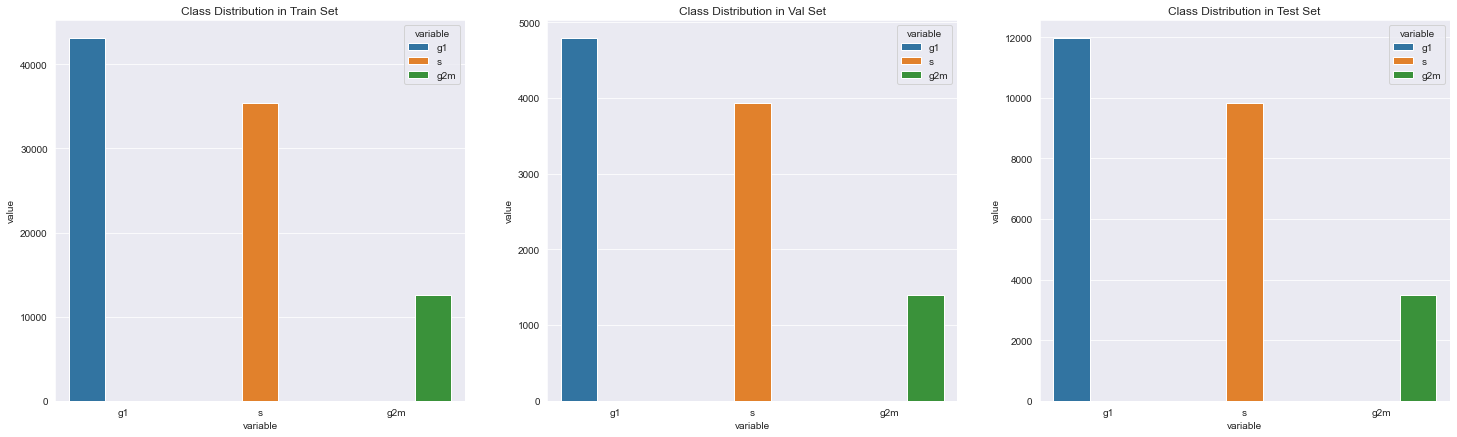

In [13]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [14]:
from torch.utils.data.dataset import Dataset
import torch


class ClassifierDataset(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [15]:
from torch.utils.data import WeightedRandomSampler

target_list = []
for _, t in train_dataset:
    target_list.append(t)

target_list = torch.tensor(target_list)

class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float)
class_weights_all = class_weights[target_list]
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [26]:
from torch import nn, optim
from torch.utils.data import DataLoader

EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = 5
NUM_CLASSES = 3

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
                          )
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()

        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)

        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_out(x)

        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=5, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [20]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)

    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)

    acc = torch.round(acc * 100)

    return acc

In [21]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [27]:
from tqdm.notebook import tqdm

print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):

    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()

        y_train_pred = model(X_train_batch)

        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)

        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()


    # VALIDATION
    with torch.no_grad():

        val_epoch_loss = 0
        val_epoch_acc = 0

        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)

            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)

            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))


    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Begin training.


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.32649 | Val Loss: 0.44243 | Train Acc: 80.041| Val Acc: 79.267
Epoch 002: | Train Loss: 0.30412 | Val Loss: 0.45078 | Train Acc: 80.713| Val Acc: 78.812
Epoch 003: | Train Loss: 0.29974 | Val Loss: 0.45949 | Train Acc: 80.920| Val Acc: 77.824
Epoch 004: | Train Loss: 0.29782 | Val Loss: 0.45539 | Train Acc: 80.930| Val Acc: 78.624
Epoch 005: | Train Loss: 0.29549 | Val Loss: 0.46164 | Train Acc: 81.092| Val Acc: 78.229
Epoch 006: | Train Loss: 0.29425 | Val Loss: 0.46541 | Train Acc: 81.206| Val Acc: 77.883
Epoch 007: | Train Loss: 0.28849 | Val Loss: 0.43966 | Train Acc: 81.392| Val Acc: 78.506
Epoch 008: | Train Loss: 0.28681 | Val Loss: 0.44731 | Train Acc: 81.362| Val Acc: 78.812
Epoch 009: | Train Loss: 0.28734 | Val Loss: 0.43140 | Train Acc: 81.217| Val Acc: 79.158
Epoch 010: | Train Loss: 0.28598 | Val Loss: 0.45622 | Train Acc: 81.365| Val Acc: 77.261
Epoch 011: | Train Loss: 0.28455 | Val Loss: 0.45966 | Train Acc: 81.498| Val Acc: 77.982
Epoch 012:

KeyboardInterrupt: 

In [39]:
#Trying xgboot classifier
import xgboost

X = np.dstack((get_label_values(df))).squeeze()
y = get_cell_labels(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42, shuffle=True)

xg = xgboost.XGBClassifier()
xg.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [40]:
#Accuracy function
from sklearn.metrics import accuracy_score
def class_pred_acc(model,values,gt):
    preds = model.predict(values)
    return accuracy_score(gt, preds)

print(class_pred_acc(xg,X_test,y_test))

0.8284584980237154


In [41]:
print(len(X_train),len(X_test))

125221 1265


In [ ]:
#Look into if there's more features we can collect on these cells
#Could be good for an RFC

In [ ]:
#Could also make use of the PCNA images with the other data

In [219]:
print(values_predictions)

[[0.26701209 0.07297885 0.21502775 0.08167543 1.07590322]
 [0.31337756 0.0936574  0.2561175  0.04560653 1.33358816]
 [0.26285994 0.10235551 0.21741169 0.04931917 1.49632523]
 ...
 [0.28314161 0.08428298 0.20223175 0.0636438  1.22602824]
 [0.26230655 0.10990231 0.22570132 0.08299008 1.61579281]
 [0.29674985 0.12230165 0.21580757 0.08387676 1.80925236]]


In [227]:
#Let's train the neural network now

from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=10000)
clf = clf.fit(X_train, y_train)

In [228]:
from sklearn.metrics import accuracy_score

#Accuracy function
def class_pred_acc(model,values,gt):
    preds = model.predict(values)
    return accuracy_score(gt, preds)

print(class_pred_acc(clf, X_test,y_test))

0.6489153121244703


In [229]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

sgd = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
sgd = sgd.fit(X_train, y_train)
print(class_pred_acc(sgd,X_test,y_test))

0.6467965340585669


In [230]:
cell_labels = get_cell_labels(df)
indices = np.arange(len(pcna_crops_flat_pad))
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(pcna_crops_flat_pad, cell_labels, indices, test_size=0.5, random_state=42, shuffle=False)
pcna_values_del = np.delete(pcna_values, indices_train)
values_predictions = get_value_predictions(X_test,[dapi_mod,cyclina2_mod,edu_mod,dna_mod],pcna_values_del)

cell_labels = np.delete(cell_labels,indices_train) #dropping the training data points

X_train, X_test, y_train, y_test = train_test_split(values_predictions, cell_labels, test_size=0.5, random_state=42)

In [232]:
from sklearn.kernel_approximation import RBFSampler

rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(values_predictions)
clf = SGDClassifier(max_iter=1000)
clf.fit(X_features, y)
SGDClassifier(max_iter=1000)
clf.score(X_features, y)

0.4366807393703651

In [181]:
def get_elbow(curve):
    # source:https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec ** 2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    return idxOfBestPoint

def get_avg_split_arr(arr, num_splits):
    array_split = np.array_split(arr, num_splits)
    averages = [mean(array) for array in array_split]
    return averages

def get_EdU_threshold(edu_nums):
    #edu_nums = np.sort(np.array(df.loc[:, [column_name]]).flatten())  # extract EdU values and put them in one array shape num_of_cells
    # Get the list of EdU values
    # Make a split from 3 to the total number of cells
    # Get the averages at that split
    # Get the elbow in those averages
    # Store that elbow in a list
    # Average out the list of elbow and return that value
    elbows_y = []
    start = round(0.73*len(edu_nums)) #we don't want to average out all of the cells because that would create a much a lower value so we only keep the top quarter
    for i in range(start, len(edu_nums) + 1):
        avg_split_arr = get_avg_split_arr(edu_nums, i)
        elbow_x = get_elbow(avg_split_arr)
        elbows_y.append(edu_nums[elbow_x])
    return mean(elbows_y)

In [182]:

def apply_rules(values_predictions):
    #want to separate out the dapi values from the cyclin a2 values and the others etc.
    dapi_values = values_predictions[:,0]
    cyclina2_values = values_predictions[:,1]
    edu_values = values_predictions[:,2]
    dna_values = values_predictions[:,3]

    edu_thresh = get_EdU_threshold(edu_values[:250])
    cyclina2_thresh = get_EdU_threshold(cyclina2_values[:250])

    preds = []
    for i in range(len(values_predictions)):
        if edu_values[i] >= edu_thresh: preds.append(1) #s
        elif cyclina2_values[i] < cyclina2_thresh and edu_values[i] < edu_thresh and dna_values[i] < 1.5: preds.append(0) #g1
        elif dna_values[i] > 1.5 and cyclina2_values[i] > cyclina2_thresh and edu_values[i] < edu_thresh: preds.append(2) #g2m

    return preds

In [193]:
cell_labels = get_cell_labels(df)
indices = np.arange(len(pcna_crops_flat_pad))

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(pcna_crops_flat_pad, cell_labels, indices, test_size=0.5, random_state=42, shuffle=False)

values_predictions = get_value_predictions(X_test,[dapi_mod,cyclina2_mod,edu_mod,dna_mod])

In [198]:
X = values_predictions
y = cell_labels

df_test = pd.DataFrame(list(zip(X,y)),columns=['X','y'])
print(df_test[:20])

                                                    X  y
0   [0.07297884556833448, 0.21502774912679135, 0.0...  0
1   [0.0936574029812724, 0.25611750030191666, 0.04...  0
2   [0.10235550715260495, 0.21741169459594326, 0.0...  0
3   [0.0746306168712752, 0.21827037606024718, 0.09...  0
4   [0.05883775160158323, 0.1610087322680655, 0.01...  0
5   [0.19211636390264408, 0.3190461898414219, 0.11...  0
6   [0.07468121534336553, 0.2047367302888031, 0.09...  0
7   [0.07348525783072753, 0.2257221851233472, 0.07...  0
8   [0.07829013783588076, 0.2065336391920153, 0.06...  0
9   [0.06554901224195551, 0.1972760959235117, 0.06...  0
10  [0.0748519808713347, 0.1944836572266424, 0.057...  0
11  [0.07428322736241541, 0.2054121124224478, 0.03...  0
12  [0.07337421166564737, 0.19928498621839658, 0.0...  0
13  [0.05024048345919645, 0.2070022426461826, 0.06...  0
14  [0.07491501975437462, 0.1949924865625282, 0.07...  0
15  [0.06642725550620043, 0.18841266345388183, 0.0...  0
16  [0.07551358044857376, 0.165

In [200]:
#Result from applying the rules
#This may be due to the thresholds not being representative as we usually calculate them on one cell image not that man

predictions_rules = apply_rules(X)

correct = 0
for i in range(len(predictions_rules)):
    if predictions_rules[i] == y[i]:
        correct += 1

print(correct*100/len(predictions_rules))

40.68790588065984


In [209]:
#Lets try randomforest
#why am I not including PCNA in this??? thats the real next step hahaha

#lets make a dataframe

df_rfc = pd.DataFrame(list(zip(values_predictions[:,0],values_predictions[:,1],values_predictions[:,2],values_predictions[:,3],cell_labels)),columns=['dapi','cyclina2','edu','dna','labels'])

X = df_rfc.iloc[:, 0:4].values
y = df_rfc.iloc[:, 4].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

from sklearn.ensemble import RandomForestClassifier

regressor = RandomForestClassifier(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

#print(confusion_matrix(y_test,y_pred))


In [212]:
#print(classification_report(y_test,y_pred))
correct = 0
for i in range(len(y_pred)):
    if y_pred[i] == y_test[i]:
        correct += 1

print(correct*100/len(y_pred))

42.904577436951534


In [213]:
print(y_pred)

[0 0 0 ... 1 1 2]


In [ ]:
#we also need to compare then with the ground truth values

In [ ]:
#need to print a bunch of them with their predictions and their real value next to them
#especially for the edu_mod one that seems terribly wrong

In [ ]:
#need to plot the predictions and the rest by showing how much they are off by

In [ ]:


#Get train and test. Done

#Time the first 1000 to see how long it will take us for the 138k. Not useful right now

#could also augment with rotations, although they might be ignored here since the crop is flattened. Need to research this.

#also need to make these predictions on other values, lets put all of this into a function. Done

#instead of applying the rules, we could make a tiny NN that takes these 4 values and predicts the label

#So to get the new data and only get the segmentations not the entire crop with the background I'll have to go back to Richmond and that will take another 4 hours
#Anyway, for now I'm seeing if this is able to guess the cell label accordingly
#Could try once with applying the rules

#will try dropping some model predictions just to see if it performs better without them
#to be faire a neural network would learn to ignore the useless ones

#might be better to get confidence labels rather than hard classification
#it would be cool to compare that with the confidence with the threshold (how far it is from the threshold) for the training data rules classification

#will try applying the rules on those predictions after, could make a simple function now that we have the 'get_value_predictions' function

In [ ]:
#Later on we will want to just have the segmentations of the cells from the mask and not have the background, as in the background should just be zeros, that would probably even make this model more accurate